In [2]:
if (!require(tidyverse, quietly = TRUE)) {
  install.packages("tidyverse")
}
if (!require(dplyr, quietly = TRUE)) {
  install.packages("dplyr")
}
if (!require(ggplot2, quietly = TRUE)) {
  install.packages("ggplot2")
}
if (!require(png, quietly = TRUE)) {
  install.packages("png")
}
# if (!require(magick, quietly = TRUE)) {
#   install.packages("magick")
# }
if (!require(grid, quietly = TRUE)) {
  install.packages("grid")
}
if (!require(tidyr, quietly = TRUE)) {
  install.packages("tidyr")
}
if (!require(car, quietly = TRUE)) {
  install.packages("car")
}
if (!require(ggmosaic, quietly = TRUE)) {
  install.packages("ggmosaic")
}

if (!require(devtools, quietly = TRUE)) {
  install.packages("devtools")
}
library(devtools)
install_github("Gibbsdavidl/CatterPlots")
library(CatterPlots)

library(tidyverse)
library(dplyr)
library(ggplot2)
library(png)
# library(magick)
library(grid)
library(tidyr)
library(car)
library(ggmosaic)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘later’, ‘plyr’, ‘htmlwidgets


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpwt29im/remotes271365499b8/Gibbsdavidl-CatterPlots-ae17cd5/DESCRIPTION’ ... OK
* preparing ‘CatterPlots’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘CatterPlots_0.0.2.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Welcome to CatterPlots.


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




In [3]:
getwd()

[1] "/content"

In [4]:
viz_folder_path <- "../Visualizations"

In [5]:
processed_data <- read.csv("../Data/processed_salary_data.csv", check.names=FALSE)

# Exploratory Data Analysis

In [6]:
df <- data.frame(processed_data)
df["annual_salary"] = df["annual_salary"] + df["annual_bonus"]
df = df[,!(names(df) %in% c("annual_bonus"))]

## Univariate Analysis

distribution of variables i.e. histogram/barchart, density func...

Summarize numeric variables; our only two continuous ones are annual_salary and annual_bonus. The others are categorical i.e. race "White" etc. and given ranges i.e. experience years "15-20" etc.

In [7]:
numeric_vars <- df %>% select_if(is.numeric)
summary(numeric_vars)

     Var.1       annual_salary    
 Min.   :    1   Min.   :      0  
 1st Qu.: 6562   1st Qu.:  59200  
 Median :13726   Median :  82500  
 Mean   :13750   Mean   : 103134  
 3rd Qu.:20761   3rd Qu.: 121000  
 Max.   :27940   Max.   :3600000  

We can visualize those numeric variables via histograms

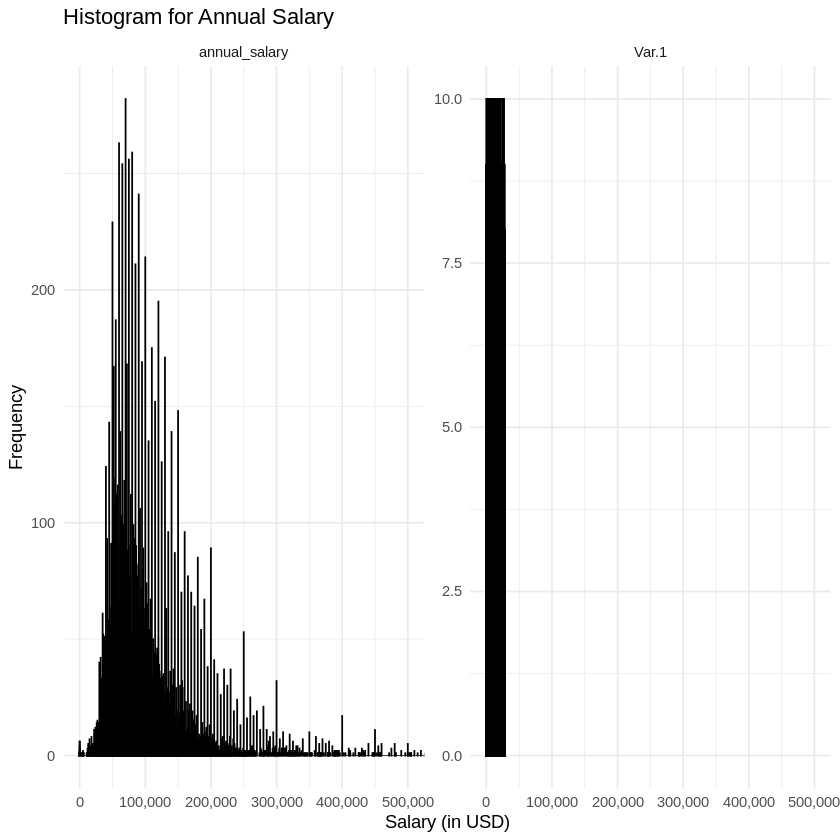

In [8]:
histograms <- numeric_vars %>%
  gather() %>%
  ggplot(aes(x = value)) +
  geom_histogram(binwidth = 10, fill = "blue", color = "black", alpha = 0.7) +
  facet_wrap(~key, scales = "free") +
  labs(title = "Histogram for Annual Salary", x = "Salary (in USD)", y = "Frequency") +
  scale_x_continuous(labels = scales::comma) +
  coord_cartesian(xlim = c(0, 500000)) +
  theme_minimal()

print(histograms)

We can also visualize those numeric variables via boxplots

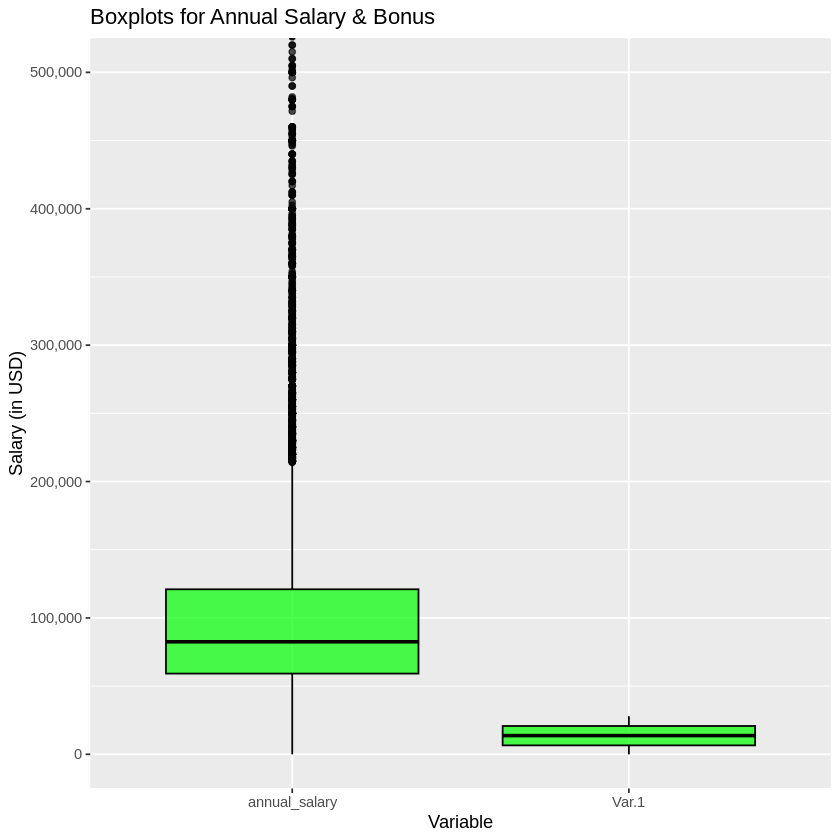

In [9]:
boxplots <- numeric_vars %>%
  gather() %>%
  ggplot(aes(key, value)) +
  geom_boxplot(fill = "green", color = "black", alpha = 0.7) +
  labs(title = "Boxplots for Annual Salary & Bonus", x = "Variable", y = "Salary (in USD)") +
  scale_y_continuous(labels = scales::comma) +
  coord_cartesian(ylim = c(0, 500000))

print(boxplots)

### Outlier Detection & Handling

We identify potential outliers above, indicated by the dots. Can use IQR to detect outliers. Not all outliers are influential. We can identify the influential ones in our regression analysis i.e. via Cook's distance.

Step one is identifying the outliers (and seeing after if they're influential)

Step two is dealing with them i.e. do we delete? As we've seen in class, that depends (i.e. if incorrect input vs important pattern that linear models can't deal with). Do we keep them and find better model? Do we impute other values i.e. IQR?

In [10]:
detect_outliers <- function(df, method = "IQR", threshold = 1.5) {
  outlier_rows <- list()

  for (col_name in names(df)) {
    column <- df[[col_name]]

    if (is.numeric(column)) {
      Q1 <- quantile(column, 0.25)
      Q3 <- quantile(column, 0.75)
      IQR <- Q3 - Q1
      lower_bound <- Q1 - threshold * IQR
      upper_bound <- Q3 + threshold * IQR

      outlier_indices <- which(column < lower_bound | column > upper_bound)
      if (length(outlier_indices) > 0) {
        outlier_rows[[col_name]] <- df[outlier_indices, ]
      }
    }
  }

  return(outlier_rows)
}

outlier_results <- detect_outliers(df)
outlier_results

,Var.1,age,industry,job_title,annual_salary,state,overall_experience_years,field_experience_years,education_level,gender,race,date
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
22,33,25-34,"Accounting, Banking & Finance",Financial Advisor,230000,Missouri,11 - 20 years,11 - 20 years,College degree,Woman,White,2021-04-27
36,48,35-44,Computing or Tech,Product Design Director,240850,North Carolina,11 - 20 years,11 - 20 years,College degree,Woman,White,2021-04-27
64,92,55-64,Business or Consulting,Senior Vice President of Marketing,240000,Massachusetts,31 - 40 years,11 - 20 years,Master's degree,Woman,White,2021-04-27
117,176,35-44,"Marketing, Advertising & PR",Brand Consultant,400000,New York,11 - 20 years,11 - 20 years,College degree,Woman,White,2021-04-27
126,190,45-54,Law,Senior Corporate Counsel,220000,California,11 - 20 years,11 - 20 years,PhD,Woman,Asian or Asian American,2021-04-27
142,214,55-64,Law,Attorney,275000,Minnesota,31 - 40 years,31 - 40 years,Master's degree,Woman,White,2021-04-27
229,354,35-44,Computing or Tech,Senior user experience researcher,309000,New York,11 - 20 years,8 - 10 years,PhD,Woman,White,2021-04-27
254,385,45-54,Computing or Tech,Sr development Manager,350000,Colorado,21 - 30 years,11 - 20 years,College degree,Man,White,2021-04-27
282,426,45-54,Law,Equity Partner,600000,Pennsylvania,21 - 30 years,21 - 30 years,PhD,Woman,White,2021-04-27


We can visualize those outliers i.e. what do they have in common. We can find outliers by groups as well. We'll analyze those more later on.

Now for the categorical variables, let's find and summarize them

In [11]:
df$education_level = as.factor(df$education_level)
df$gender = as.factor(df$gender)
df$state = as.factor(df$state)

In [12]:
categorical_vars <- df %>% select_if(is.factor)
# table(categorical_vars)
categorical_vars

state,education_level,gender
<fct>,<fct>,<fct>
Massachusetts,Master's degree,Woman
Tennessee,College degree,Woman
Wisconsin,College degree,Woman
South Carolina,College degree,Woman
New Hampshire,Master's degree,Man
Arizona,Master's degree,Man
Missouri,College degree,Woman
Florida,College degree,Woman
Pennsylvania,PhD,Woman


In [13]:
table(categorical_vars)

, , gender = Man

                      education_level
state                  College degree High School Master's degree PhD
  Alabama                           8           0               6   1
  Alaska                            4           0               2   0
  Arizona                          22           1               9   2
  Arkansas                          3           0               6   0
  California                      262          14             100  29
  Colorado                         58           6              33   2
  Connecticut                      12           0               6   1
  Delaware                          0           0               0   0
  District of Columbia             48           3              37   4
  Florida                          48           2              21   2
  Georgia                          36           3              13   4
  Hawaii                            1           0               1   0
  Idaho                           

Now we can create barplots for our categorical variables

Warning message:
“attributes are not identical across measure variables; they will be dropped”


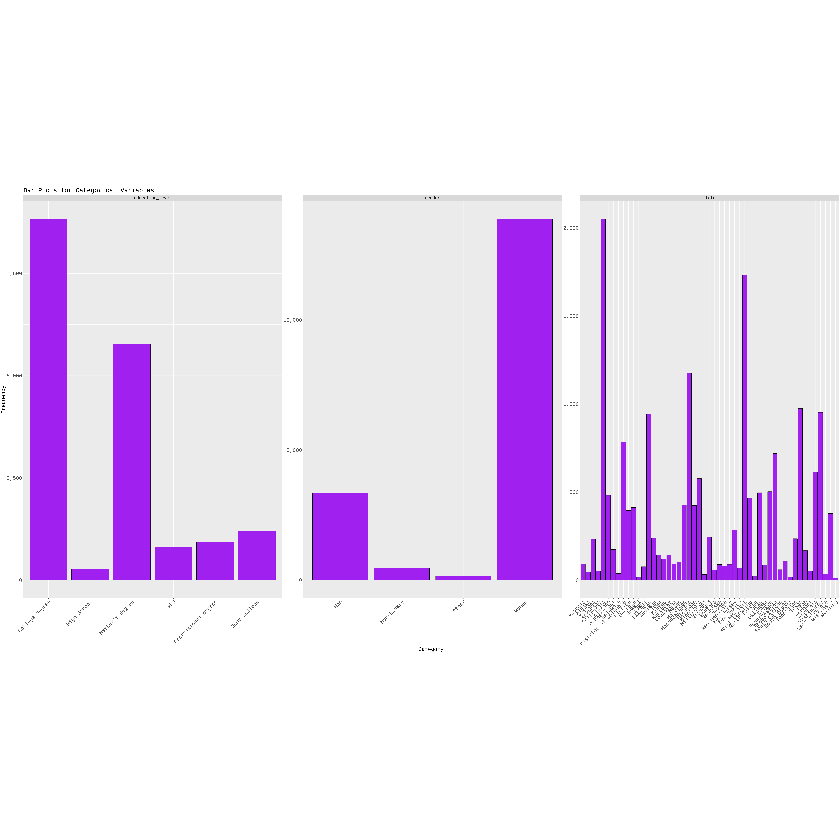

In [14]:
barplots <- categorical_vars %>%
  gather() %>%
  ggplot(aes(x = value)) +
  geom_bar(fill = "purple", color = "black") +
  facet_wrap(~key, scales = "free") +
  labs(title = "Bar Plots for Categorical Variables", x = "Category", y = "Frequency") +
  scale_y_continuous(labels = scales::comma) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 20),
        axis.text.y = element_text(hjust = 1, size = 20),
        text = element_text(size = 20))
save_path = file.path(viz_folder_path, "eda_categorical_barplot.png")
ggsave(save_path, barplots, height = 25, width = 45)
#read file
img <- readPNG(save_path)
grid::grid.raster(img)

In [15]:
table(df$industry)


       Accounting, Banking & Finance              Agriculture or Forestry 
                                1161                                   84 
                        Art & Design               Business or Consulting 
                                 247                                  587 
                   Computing or Tech         Education (Higher Education) 
                                3192                                 1817 
       Education (Primary/Secondary)         Engineering or Manufacturing 
                                 624                                 1149 
                       Entertainment Government and Public Administration 
                                 175                                 1207 
                         Health care                 Hospitality & Events 
                                1308                                  171 
                           Insurance                                  Law 
                        

## Bivariate Analysis

Now we analyze relations between variables.

First, let's analyze the relation between our target variable, annual salary, and other categorical variables.

We can visualize the distribution of salaries across different categories for each categorical variable.

In [16]:
categorical_variables = c("age",
                          "industry",
                          "state",
                          "overall_experience_years",
                          "field_experience_years",
                          "education_level",
                          "gender",
                          "race")

In [17]:
for (category_variable in categorical_variables) {
  boxplot_plot <- ggplot(df, aes(x = df[[category_variable]], y = df$annual_salary)) +
    geom_boxplot(fill = "lightblue") +
    labs(title = paste("Box Plot of Annual Salary by", category_variable),
         x = category_variable,
         y = "Annual Salary") +
    scale_y_continuous(labels = scales::comma) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 12)) +
    coord_cartesian(ylim = c(0, 500000))
  save_path = file.path(viz_folder_path, paste0("eda_bivariate_boxplot_", category_variable, ".png"))
  ggsave(save_path, boxplot_plot, height = 8, width = 8)

}

Warning message:
“Use of `df[[category_variable]]` is discouraged.
ℹ Use `.data[[category_variable]]` instead.”
Warning message:
“Use of `df$annual_salary` is discouraged.
ℹ Use `annual_salary` instead.”
Warning message:
“Use of `df[[category_variable]]` is discouraged.
ℹ Use `.data[[category_variable]]` instead.”
Warning message:
“Use of `df$annual_salary` is discouraged.
ℹ Use `annual_salary` instead.”
Warning message:
“Use of `df[[category_variable]]` is discouraged.
ℹ Use `.data[[category_variable]]` instead.”
Warning message:
“Use of `df$annual_salary` is discouraged.
ℹ Use `annual_salary` instead.”
Warning message:
“Use of `df[[category_variable]]` is discouraged.
ℹ Use `.data[[category_variable]]` instead.”
Warning message:
“Use of `df$annual_salary` is discouraged.
ℹ Use `annual_salary` instead.”
Warning message:
“Use of `df[[category_variable]]` is discouraged.
ℹ Use `.data[[category_variable]]` instead.”
Warning message:
“Use of `df$annual_salary` is discouraged.
ℹ Use `annua

In [18]:
df %>%
    group_by(gender) %>%
    summarize(median_salary = median(annual_salary, na.rm = TRUE))

gender,median_salary
<fct>,<dbl>
Man,112000
Non-binary,63775
Other,84000
Woman,79000


In [19]:
df %>%
    group_by(state) %>%
    summarize(median_salary = median(annual_salary, na.rm = TRUE))

state,median_salary
<fct>,<dbl>
Alabama,68500.0
Alaska,74000.0
Arizona,68000.0
Arkansas,60000.0
California,109000.0
Colorado,80000.0
Connecticut,85000.0
Delaware,80072.5
District of Columbia,93000.0


In [20]:
df %>%
    group_by(race) %>%
    summarize(median_salary = median(annual_salary, na.rm = TRUE))

race,median_salary
<chr>,<dbl>
Asian or Asian American,103000
Black or African American,82500
Hispanic,80000
Middle Eastern or Northern African,93013
Native American or Alaska Native,88250
White,81000


In [21]:
table(df$race, df$industry)

                                    
                                     Accounting, Banking & Finance
  Asian or Asian American                                       84
  Black or African American                                     48
  Hispanic                                                      45
  Middle Eastern or Northern African                            10
  Native American or Alaska Native                               4
  White                                                        970
                                    
                                     Agriculture or Forestry Art & Design
  Asian or Asian American                                  3           28
  Black or African American                                3            8
  Hispanic                                                 2           12
  Middle Eastern or Northern African                       0            0
  Native American or Alaska Native                         3            1
  White      

In [22]:
table(df$gender, df$industry)

            
             Accounting, Banking & Finance Agriculture or Forestry Art & Design
  Man                                  194                       9           35
  Non-binary                            12                       4           12
  Other                                 10                       0            1
  Woman                                945                      71          199
            
             Business or Consulting Computing or Tech
  Man                            89              1293
  Non-binary                     14               101
  Other                           2                32
  Woman                         482              1766
            
             Education (Higher Education) Education (Primary/Secondary)
  Man                                 207                            58
  Non-binary                           52                            14
  Other                                22                             3
  W

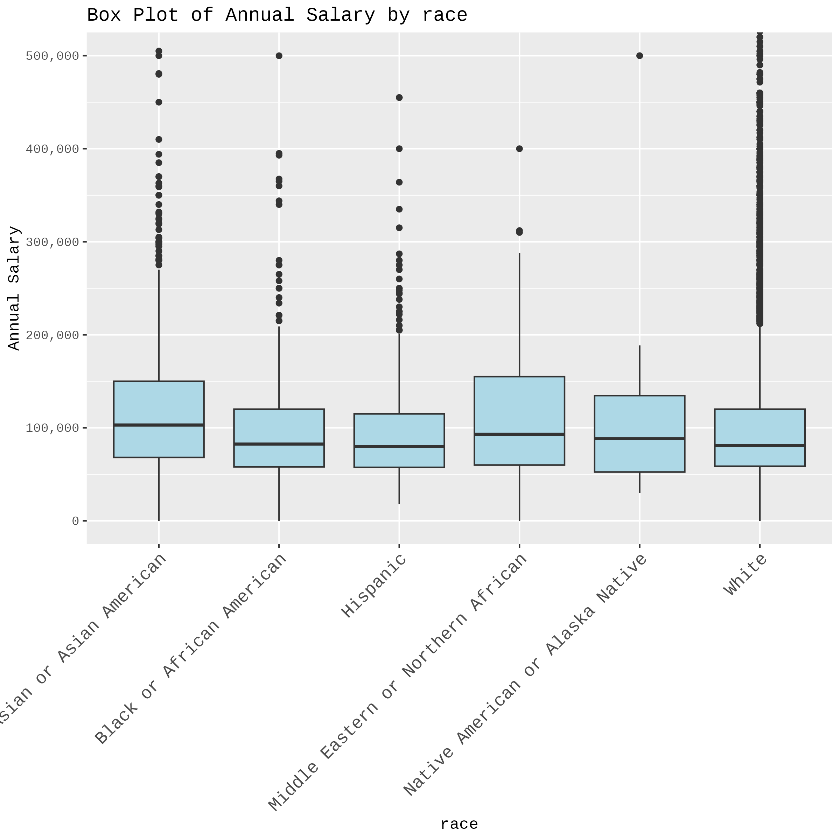

In [23]:
for (category_variable in categorical_variables) {
  save_path = file.path(viz_folder_path, paste0("eda_bivariate_boxplot_", category_variable, ".png"))
  img <- readPNG(save_path)
  grid::grid.raster(img)
}

Can't look at correlation matrix since only our salary is continuous. We'll use ANOVA to analyze the effects between continuous and categorical variables, as well as Chi-square to test between categorical variables.

In [24]:
anova_results <- list()

for (category_variable in categorical_variables) {
  anova_result <- aov(annual_salary ~ df[[category_variable]], data = df)
  anova_results[[category_variable]] <- summary(anova_result)
}

anova_summary_table <- data.frame(
  p_value = sapply(anova_results, function(x) x[[1]][["Pr(>F)"]][1]),
  stringsAsFactors = FALSE
)
anova_summary_table

,p_value
,<dbl>
age,1.060814e-64
industry,0.000000e+00
state,6.976649e-144
overall_experience_years,6.895155e-88
field_experience_years,1.929585e-179
education_level,2.545071e-94
gender,3.242363e-161
race,7.184533e-13


Check relations between categorical via mosaic plot.

In [25]:
pairwise_plots <- list()

for (i in 1:(length(categorical_variables) - 1)) {
  for (j in (i + 1):length(categorical_variables)) {
    var1 <- categorical_variables[i]
    var2 <- categorical_variables[j]

    plot <- ggplot(df, aes(x = df[[var1]], fill = df[[var2]])) +
      geom_bar() +
      labs(title = paste("Stacked Bar Plot of", var1, "vs", var2),
           x = var1,
           y = "Count") +
      theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 12))

    pairwise_plots[[paste(var1, var2, sep = "_")]] <- plot

    save_path = file.path(viz_folder_path, paste0("eda_categorical_stacked_", var1, "_", var2, ".png"))
    ggsave(save_path, plot, height = 10, width = 20)
  }
}

Warning message:
“Use of `df[[var1]]` is discouraged.
ℹ Use `.data[[var1]]` instead.”
Warning message:
“Use of `df[[var2]]` is discouraged.
ℹ Use `.data[[var2]]` instead.”
Warning message:
“Use of `df[[var1]]` is discouraged.
ℹ Use `.data[[var1]]` instead.”
Warning message:
“Use of `df[[var2]]` is discouraged.
ℹ Use `.data[[var2]]` instead.”
Warning message:
“Use of `df[[var1]]` is discouraged.
ℹ Use `.data[[var1]]` instead.”
Warning message:
“Use of `df[[var2]]` is discouraged.
ℹ Use `.data[[var2]]` instead.”
Warning message:
“Use of `df[[var1]]` is discouraged.
ℹ Use `.data[[var1]]` instead.”
Warning message:
“Use of `df[[var2]]` is discouraged.
ℹ Use `.data[[var2]]` instead.”
Warning message:
“Use of `df[[var1]]` is discouraged.
ℹ Use `.data[[var1]]` instead.”
Warning message:
“Use of `df[[var2]]` is discouraged.
ℹ Use `.data[[var2]]` instead.”
Warning message:
“Use of `df[[var1]]` is discouraged.
ℹ Use `.data[[var1]]` instead.”
Warning message:
“Use of `df[[var2]]` is discouraged.


In [26]:
table_gender_industry <- table(df$gender, df$industry)
percentages <- prop.table(table_gender_industry, margin = 1) * 100
percentages

            
             Accounting, Banking & Finance Agriculture or Forestry Art & Design
  Man                            5.8049072               0.2692998    1.0472771
  Non-binary                     2.6086957               0.8695652    2.6086957
  Other                          6.3694268               0.0000000    0.6369427
  Woman                          6.8059057               0.5113432    1.4332013
            
             Business or Consulting Computing or Tech
  Man                     2.6630760        38.6894075
  Non-binary              3.0434783        21.9565217
  Other                   1.2738854        20.3821656
  Woman                   3.4713720        12.7187613
            
             Education (Higher Education) Education (Primary/Secondary)
  Man                           6.1938959                     1.7354877
  Non-binary                   11.3043478                     3.0434783
  Other                        14.0127389                     1.9108280
  W

In [27]:
table_gender_industry <- table(df$race, df$state)
percentages <- prop.table(table_gender_industry, margin = 1) * 100
percentages

                                    
                                         Alabama      Alaska     Arizona
  Asian or Asian American             0.25488530  0.00000000  1.10450297
  Black or African American           0.17513135  0.17513135  1.05078809
  Hispanic                            0.14534884  0.00000000  2.32558140
  Middle Eastern or Northern African  0.00000000  0.95238095  1.90476190
  Native American or Alaska Native    0.00000000  0.00000000  0.00000000
  White                               0.56448966  0.28880866  1.29963899
                                    
                                        Arkansas  California    Colorado
  Asian or Asian American             0.16992353 29.22684792  1.52931181
  Black or African American           0.17513135 11.55866900  1.05078809
  Hispanic                            0.29069767 19.62209302  1.74418605
  Middle Eastern or Northern African  0.00000000 24.76190476  3.80952381
  Native American or Alaska Native    0.00000000 1

In [28]:
rowSums(percentages)

Asian or Asian American          Black or African American 
                               100                                100 
                          Hispanic Middle Eastern or Northern African 
                               100                                100 
  Native American or Alaska Native                              White 
                               100                                100

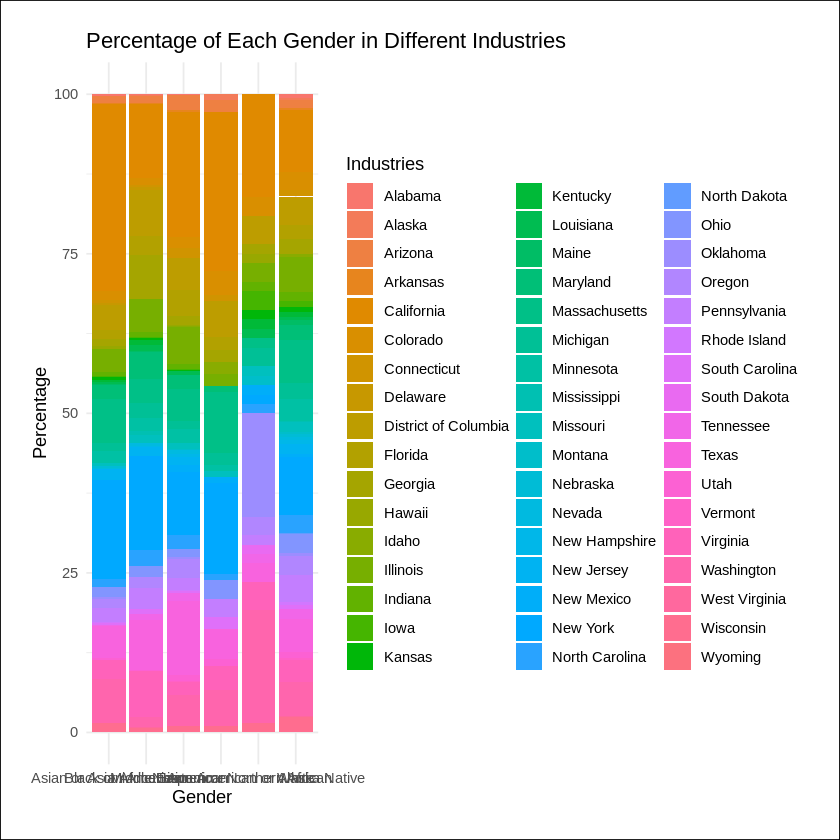

In [29]:

long_data <- as.data.frame(as.table(percentages))
p <- ggplot(long_data, aes(x=Var1, y=Freq, fill=Var2)) +
  geom_bar(stat="identity", position="stack") +
  labs(x="Gender", y="Percentage", fill="Industries",
       title="Percentage of Each Gender in Different Industries") +
  theme_minimal() +
  theme(
    legend.position="right",
    plot.margin=margin(20, 20, 20, 20),  # Adjusting plot margins
    plot.background = element_rect(fill = "white")
  )
save_path = file.path(viz_folder_path, paste0("eda_gender_industry_pct.png"))
ggsave(save_path, p, height = 8, width = 12)
print(p)

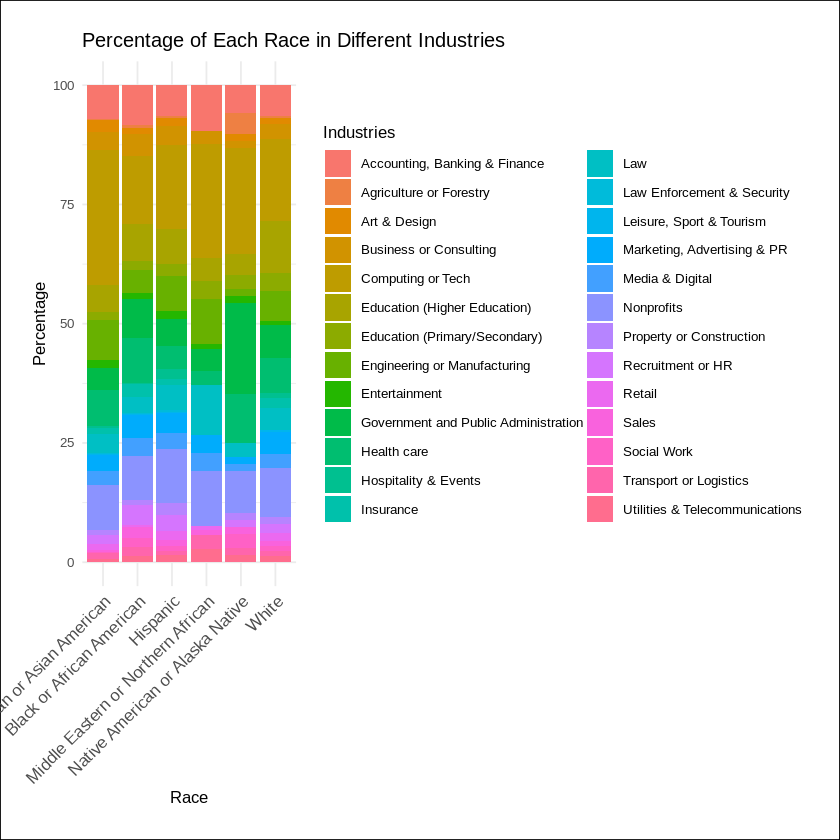

In [30]:
table_race_industry <- table(df$race, df$industry)
percentages <- prop.table(table_race_industry, margin = 1) * 100

long_data <- as.data.frame(as.table(percentages))
p <- ggplot(long_data, aes(x=Var1, y=Freq, fill=Var2)) +
  geom_bar(stat="identity", position="stack") +
  labs(x="Race", y="Percentage", fill="Industries",
       title="Percentage of Each Race in Different Industries") +
  theme_minimal() +
  theme(
    legend.position="right",
    plot.margin=margin(20, 20, 20, 20),  # Adjusting plot margins
    plot.background = element_rect(fill = "white"),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    text = element_text(size = 10)
  )
save_path = file.path(viz_folder_path, paste0("eda_race_industry_pct.png"))
ggsave(save_path, p, height = 8, width = 12)
print(p)

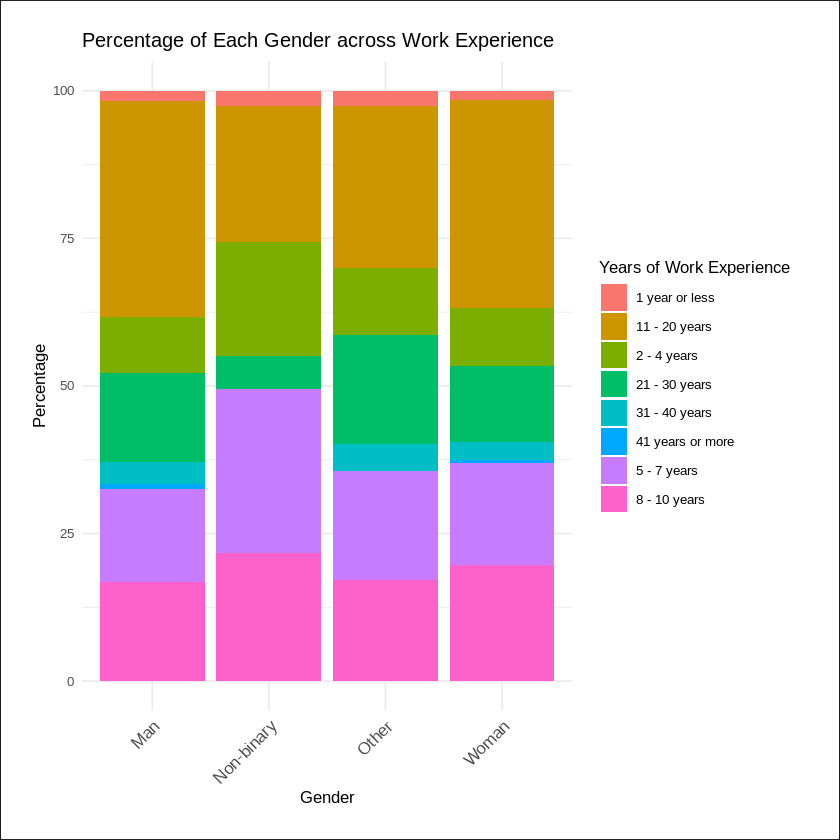

In [31]:
table_race_industry <- table(df$gender, df$overall_experience_years)
percentages <- prop.table(table_race_industry, margin = 1) * 100

long_data <- as.data.frame(as.table(percentages))
p <- ggplot(long_data, aes(x=Var1, y=Freq, fill=Var2)) +
  geom_bar(stat="identity", position="stack") +
  labs(x="Gender", y="Percentage", fill="Years of Work Experience",
       title="Percentage of Each Gender across Work Experience") +
  theme_minimal() +
  theme(
    legend.position="right",
    plot.margin=margin(20, 20, 20, 20),  # Adjusting plot margins
    plot.background = element_rect(fill = "white"),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    text = element_text(size = 10)
  )
save_path = file.path(viz_folder_path, paste0("eda_gender_yoe_pct.png"))
ggsave(save_path, p, height = 8, width = 12)
print(p)

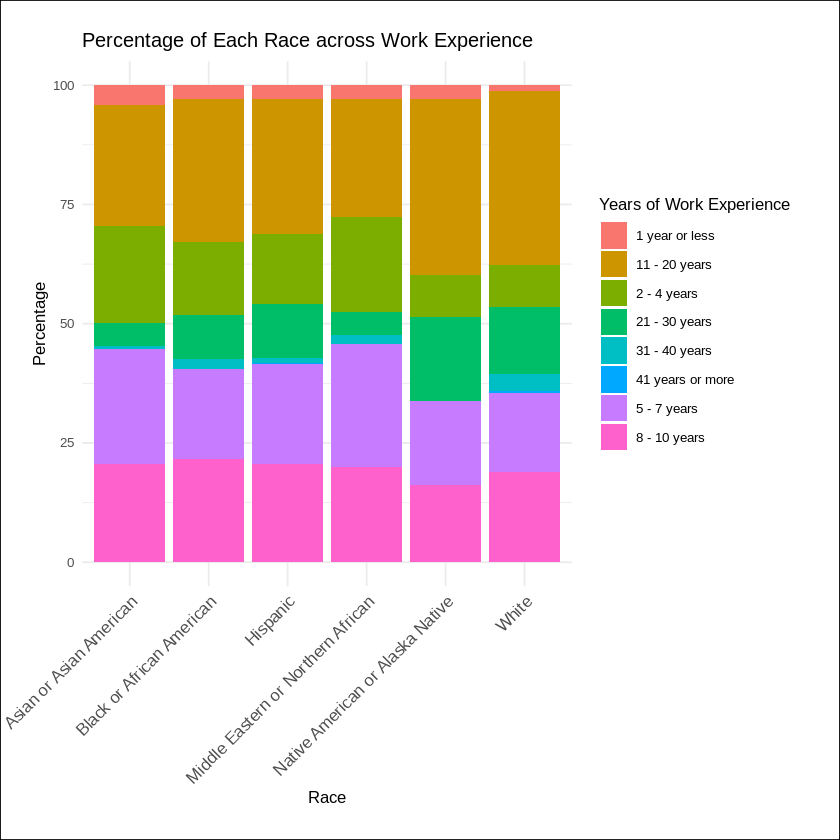

In [32]:
table_race_industry <- table(df$race, df$overall_experience_years)
percentages <- prop.table(table_race_industry, margin = 1) * 100

long_data <- as.data.frame(as.table(percentages))
p <- ggplot(long_data, aes(x=Var1, y=Freq, fill=Var2)) +
  geom_bar(stat="identity", position="stack") +
  labs(x="Race", y="Percentage", fill="Years of Work Experience",
       title="Percentage of Each Race across Work Experience") +
  theme_minimal() +
  theme(
    legend.position="right",
    plot.margin=margin(20, 20, 20, 20),
    plot.background = element_rect(fill = "white"),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    text = element_text(size = 10)
  )
save_path = file.path(viz_folder_path, paste0("eda_race_yoe_pct.png"))
ggsave(save_path, p, height = 8, width = 12)
print(p)

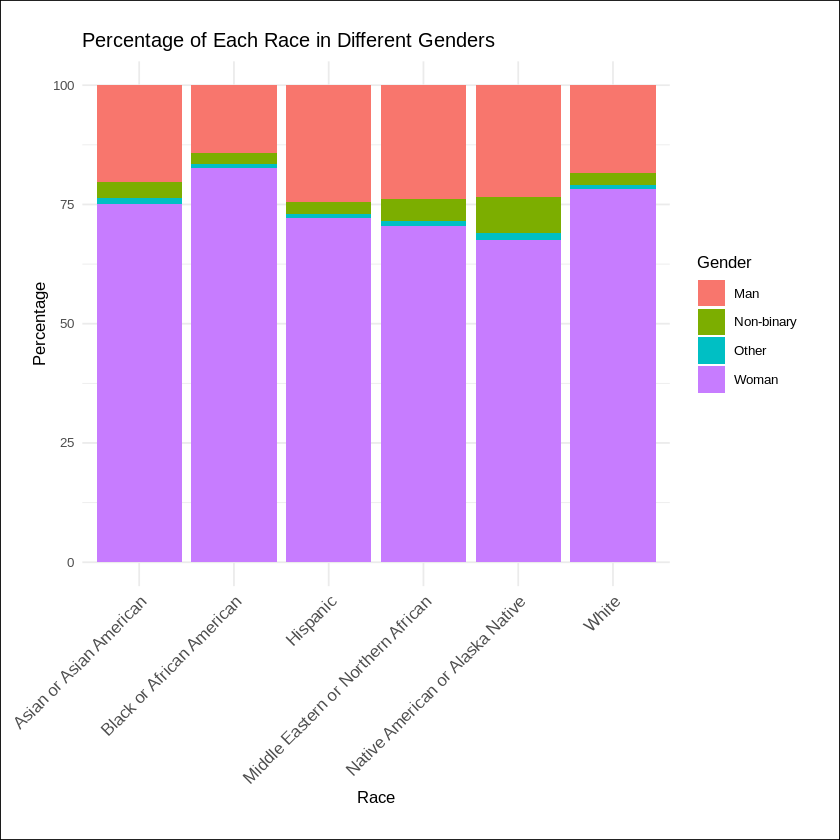

In [33]:
table_race_industry <- table(df$race, df$gender)
percentages <- prop.table(table_race_industry, margin = 1) * 100

long_data <- as.data.frame(as.table(percentages))
p <- ggplot(long_data, aes(x=Var1, y=Freq, fill=Var2)) +
  geom_bar(stat="identity", position="stack") +
  labs(x="Race", y="Percentage", fill="Gender",
       title="Percentage of Each Race in Different Genders") +
  theme_minimal() +
  theme(
    legend.position="right",
    plot.margin=margin(20, 20, 20, 20),
    plot.background = element_rect(fill = "white"),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    text = element_text(size = 10)
  )
save_path = file.path(viz_folder_path, paste0("eda_race_gender_pct.png"))
ggsave(save_path, p, height = 8, width = 12)
print(p)

We do that but with mosaic now

In [34]:
mosaic_plot = ggplot(data = long_data) +
  geom_mosaic(aes(x = product(Var1), fill = Var2)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        axis.text.y = element_text(angle = 45, hjust = 1, size = 14))
save_path = file.path(viz_folder_path, paste0("eda_mosaic_industry_gender.png"))
ggsave(save_path, mosaic_plot, height = 12, width = 18)

Warning message:
“`unite_()` was deprecated in tidyr 1.2.0.
ℹ Please use `unite()` instead.
ℹ The deprecated feature was likely used in the ggmosaic package.
  Please report the issue at <https://github.com/haleyjeppson/ggmosaic>.”


In [35]:
mosaic_plot = ggplot(data = df) +
  geom_mosaic(aes(x = product(industry), fill = age)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        axis.text.y = element_text(angle = 45, hjust = 1, size = 14))
save_path = file.path(viz_folder_path, paste0("eda_mosaic_age_industry.png"))
ggsave(save_path, mosaic_plot, height = 12, width = 18)

In [36]:
mosaic_plot = ggplot(data = df) +
  geom_mosaic(aes(x = product(industry), fill = overall_experience_years)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        axis.text.y = element_text(angle = 45, hjust = 1, size = 14))
save_path = file.path(viz_folder_path, paste0("eda_mosaic_industry_overall_experience_years.png"))
ggsave(save_path, mosaic_plot, height = 12, width = 18)

In [37]:
mosaic_plot = ggplot(data = df) +
  geom_mosaic(aes(x = product(education_level), fill = age)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        axis.text.y = element_text(angle = 45, hjust = 1, size = 14))
save_path = file.path(viz_folder_path, paste0("eda_mosaic_age_education_level.png"))
ggsave(save_path, mosaic_plot, height = 12, width = 18)

In [38]:
mosaic_plot = ggplot(data = df) +
  geom_mosaic(aes(x = product(race), fill = education_level)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        axis.text.y = element_text(angle = 45, hjust = 1, size = 14))
save_path = file.path(viz_folder_path, paste0("eda_mosaic_race_education_level.png"))
ggsave(save_path, mosaic_plot, height = 12, width = 18)

In [39]:
mosaic_plot = ggplot(data = df) +
  geom_mosaic(aes(x = product(industry), fill = race)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        axis.text.y = element_text(angle = 45, hjust = 1, size = 14))
save_path = file.path(viz_folder_path, paste0("eda_mosaic_race_industry.png"))
ggsave(save_path, mosaic_plot, height = 15, width=21)

In [40]:
mosaic_plot = ggplot(data = df) +
  geom_mosaic(aes(x = product(race), fill = overall_experience_years)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        axis.text.y = element_text(angle = 45, hjust = 1, size = 14))
save_path = file.path(viz_folder_path, paste0("eda_mosaic_race_overall_years_experience.png"))
ggsave(save_path, mosaic_plot, height = 15, width=21)

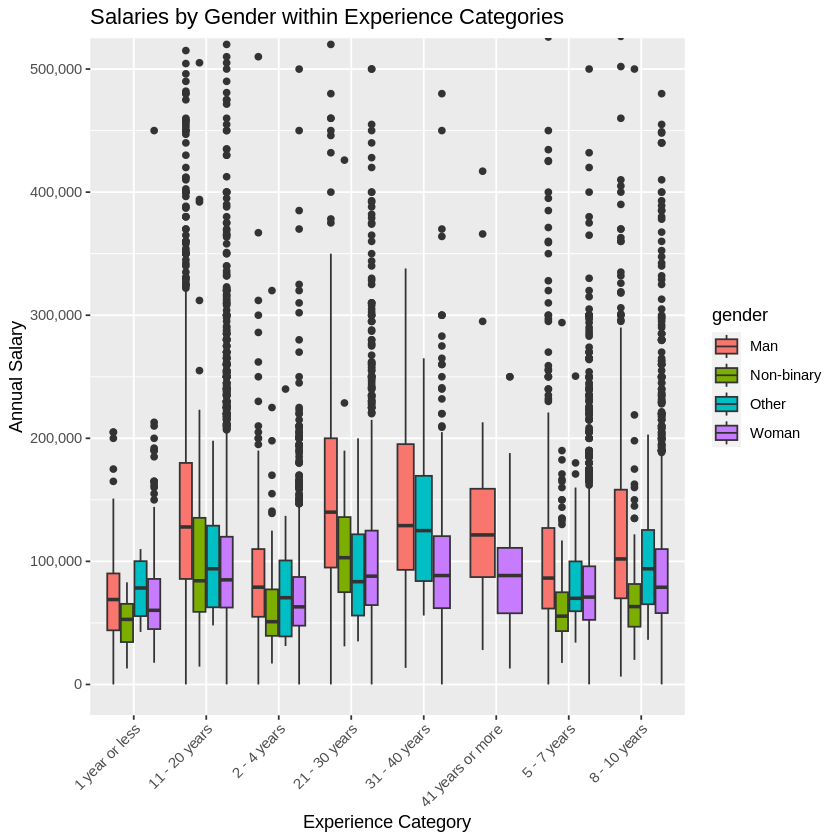

In [41]:
ggplot(df, aes(x=overall_experience_years, y=annual_salary, fill=gender)) +
  geom_boxplot() +
  labs(title="Salaries by Gender within Experience Categories", x="Experience Category", y="Annual Salary") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_y_continuous(labels = scales::comma) +
  coord_cartesian(ylim = c(0, 500000))

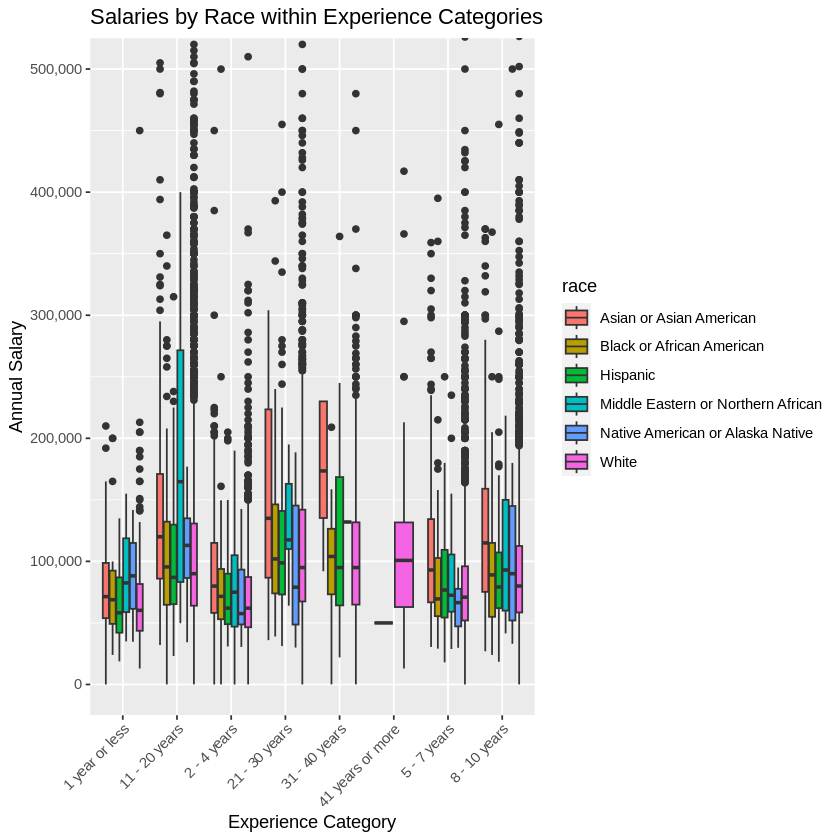

In [42]:
ggplot(df, aes(x=overall_experience_years, y=annual_salary, fill=race)) +
  geom_boxplot() +
  labs(title="Salaries by Race within Experience Categories", x="Experience Category", y="Annual Salary") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_y_continuous(labels = scales::comma) +
  coord_cartesian(ylim = c(0, 500000))

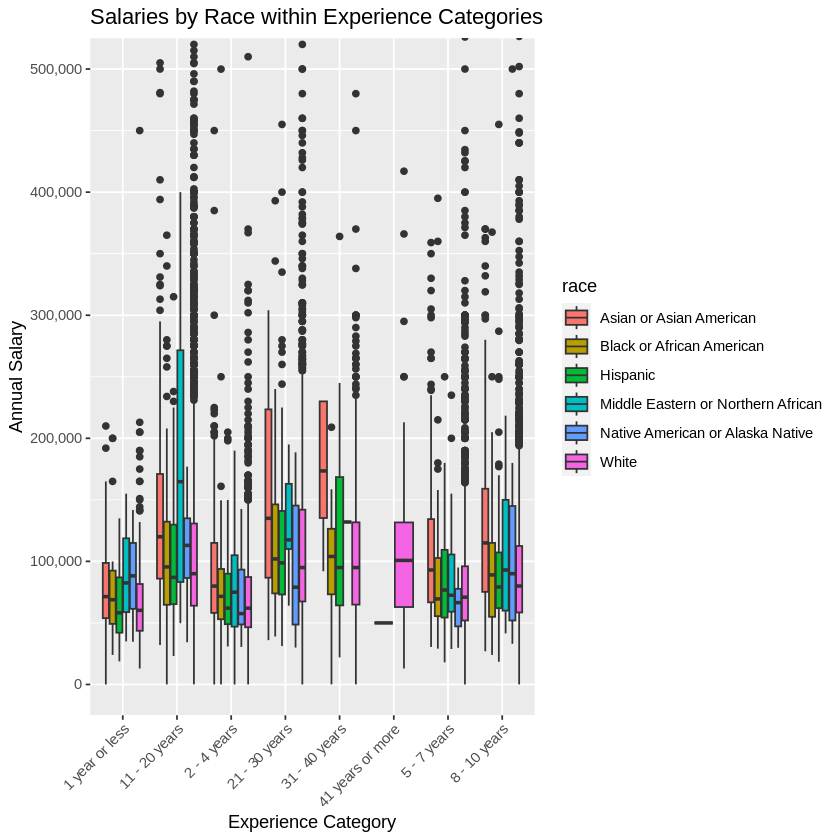

In [43]:
ggplot(df, aes(x=overall_experience_years, y=annual_salary, fill=race)) +
  geom_boxplot() +
  labs(title="Salaries by Race within Experience Categories", x="Experience Category", y="Annual Salary") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_y_continuous(labels = scales::comma) +
  coord_cartesian(ylim = c(0, 500000))

In [44]:
chi_square_results <- c()

for (i in 1:(length(categorical_variables) - 1)) {
  for (j in (i+1):(length(categorical_variables) - 1)) {
    var1 = categorical_variables[i]
    var2 = categorical_variables[j]
    contingency_table <- table(df[, c(var1, var2)])
    chi_square_result <- chisq.test(contingency_table)$p.value
    chi_square_results[paste0(var1, "__", var2)] <- chi_square_result
  }
}

data.frame(chi_square_results)

Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency_table):


,chi_square_results
,<dbl>
age__industry,4.686168e-59
age__state,3.404620e-25
age__overall_experience_years,0.000000e+00
age__field_experience_years,0.000000e+00
age__education_level,1.331425e-189
age__gender,1.040334e-34
industry__state,0.000000e+00
industry__overall_experience_years,5.503409e-33
industry__field_experience_years,2.795300e-29


In [45]:
df <- subset(df, select = -date)
head(df)

,Var.1,age,industry,job_title,annual_salary,state,overall_experience_years,field_experience_years,education_level,gender,race
,<int>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<fct>,<fct>,<chr>
1,1,25-34,Education (Higher Education),Research and Instruction Librarian,55000,Massachusetts,5 - 7 years,5 - 7 years,Master's degree,Woman,White
2,3,25-34,"Accounting, Banking & Finance",Marketing Specialist,34000,Tennessee,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4,25-34,Nonprofits,Program Manager,65000,Wisconsin,8 - 10 years,5 - 7 years,College degree,Woman,White
4,5,25-34,"Accounting, Banking & Finance",Accounting Manager,67000,South Carolina,8 - 10 years,5 - 7 years,College degree,Woman,White
5,6,25-34,Education (Higher Education),Scholarly Publishing Librarian,62000,New Hampshire,8 - 10 years,2 - 4 years,Master's degree,Man,White
6,8,25-34,Education (Primary/Secondary),Librarian,50000,Arizona,5 - 7 years,5 - 7 years,Master's degree,Man,White


In [46]:
length(unique(df$state))

[1] 51

In [47]:
west_states <- c('Washington', 'Oregon', 'California', 'Nevada', 'Idaho', 'Montana', 'Wyoming', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Hawaii')
central_states <- c('North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Oklahoma', 'Texas', 'Minnesota', 'Iowa', 'Missouri', 'Arkansas', 'Louisiana', 'Wisconsin', 'Illinois', 'Michigan', 'Indiana', 'Ohio')
east_states <- setdiff(setdiff(state.name, west_states), central_states)
df$region <- as.factor(ifelse(df$state %in% west_states, "West",
                   ifelse(df$state %in% central_states, "Central", "East")))

df <- df[df$race != "Option not listed here or prefer not to answer", ]
df$race <- as.factor(as.character(df$race))
table(df$race)


           Asian or Asian American          Black or African American 
                              1177                                571 
                          Hispanic Middle Eastern or Northern African 
                               688                                105 
  Native American or Alaska Native                              White 
                                68                              15235 

In [48]:
df_reg = data.frame(df)
df_reg <- subset(df_reg, select = -state)
df_reg <- df_reg[df_reg$gender %in% c("Man", "Woman"), ]
df_reg$gender <- as.factor(as.character(df_reg$gender))
head(df_reg)

,Var.1,age,industry,job_title,annual_salary,overall_experience_years,field_experience_years,education_level,gender,race,region
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<fct>,<fct>,<fct>
1,1,25-34,Education (Higher Education),Research and Instruction Librarian,55000,5 - 7 years,5 - 7 years,Master's degree,Woman,White,East
2,3,25-34,"Accounting, Banking & Finance",Marketing Specialist,34000,2 - 4 years,2 - 4 years,College degree,Woman,White,East
3,4,25-34,Nonprofits,Program Manager,65000,8 - 10 years,5 - 7 years,College degree,Woman,White,Central
4,5,25-34,"Accounting, Banking & Finance",Accounting Manager,67000,8 - 10 years,5 - 7 years,College degree,Woman,White,East
5,6,25-34,Education (Higher Education),Scholarly Publishing Librarian,62000,8 - 10 years,2 - 4 years,Master's degree,Man,White,East
6,8,25-34,Education (Primary/Secondary),Librarian,50000,5 - 7 years,5 - 7 years,Master's degree,Man,White,West


In [49]:
unique(df_reg$education_level)

[1] Master's degree     College degree      PhD                
[4] Some college        High School         Professional degree
6 Levels: College degree High School Master's degree ... Some college

In [50]:
df_reg <- df_reg[df_reg$annual_salary <= 1e6, ]

In [51]:
p <- ggplot(df_reg, aes(x=education_level, y=annual_salary)) +
  geom_boxplot() +
  labs(title="Relationship between Education Level & Salary",
       x="Education Categories",
       y="Annual Salary (USD)") +
  theme(plot.background = element_rect(fill = "white"),
        text = element_text(size = 18))
save_path = file.path(viz_folder_path, "linear_education.png")
ggsave(save_path, p, height = 8, width = 15)

In [52]:
p <- ggplot(df_reg, aes(x=age, y=annual_salary)) +
  geom_boxplot() +
  labs(title="Relationship between Age & Salary",
       x="Age Categories",
       y="Annual Salary (USD)") +
  theme(plot.background = element_rect(fill = "white"),
                text = element_text(size = 18))

save_path = file.path(viz_folder_path, "linear_age.png")
ggsave(save_path, p, height = 8, width = 15)

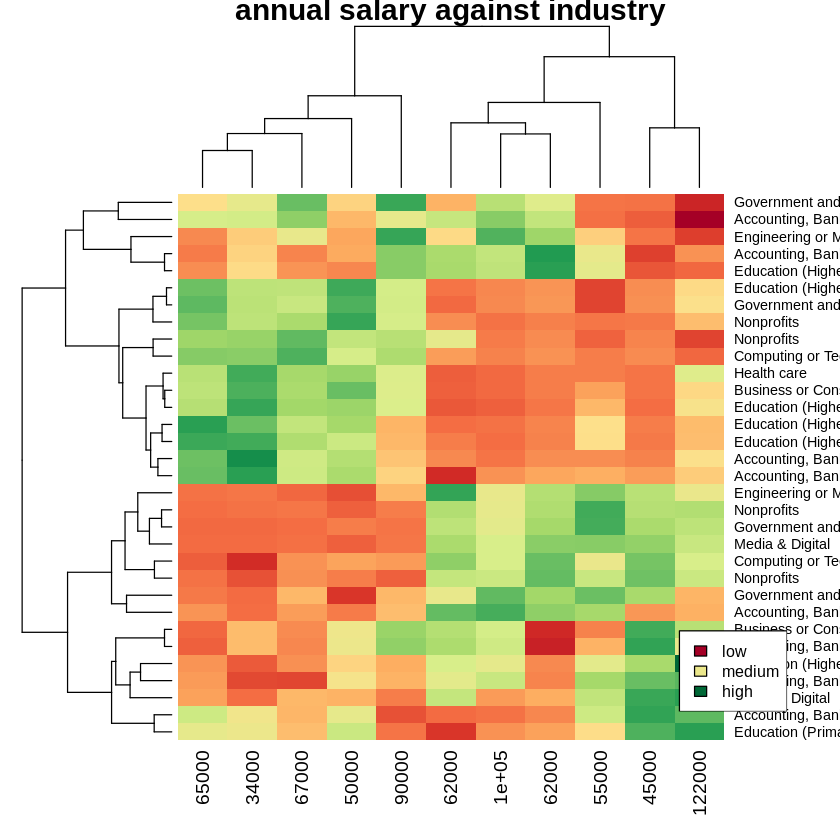

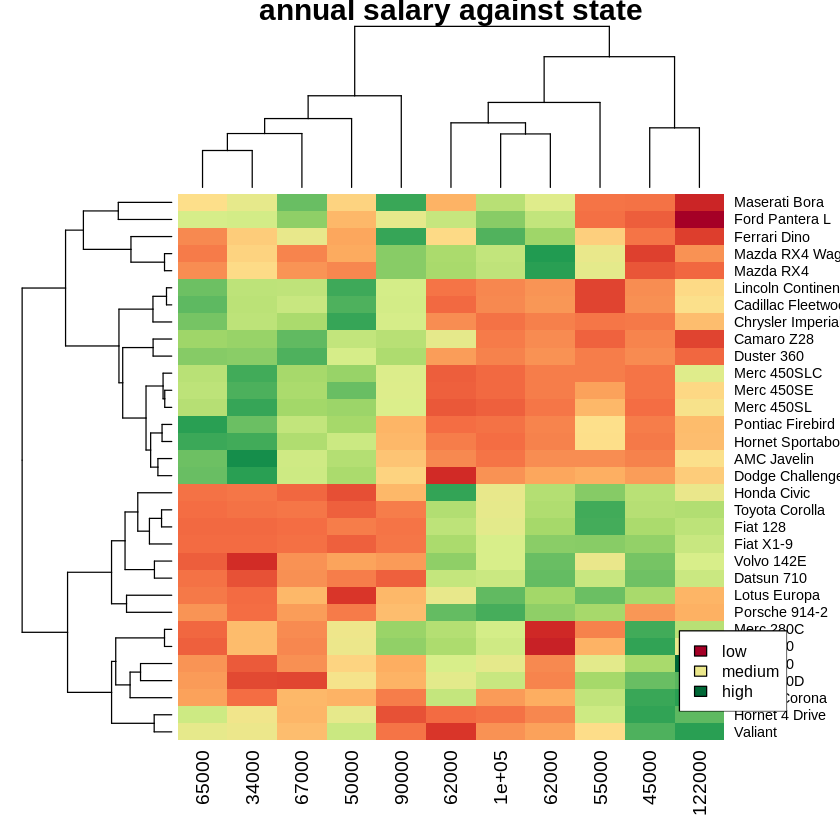

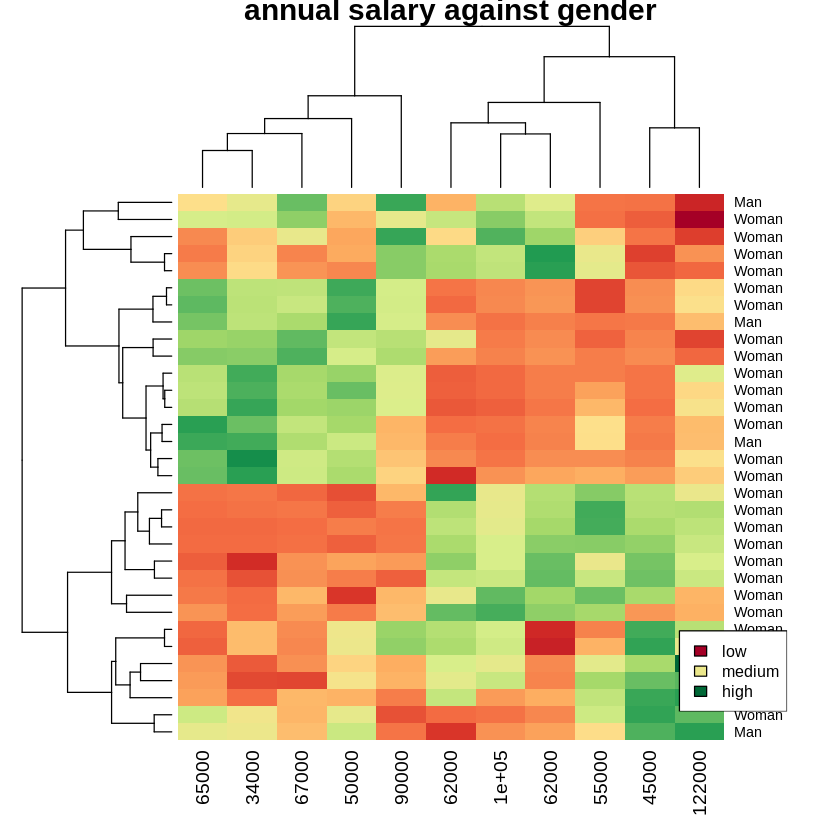

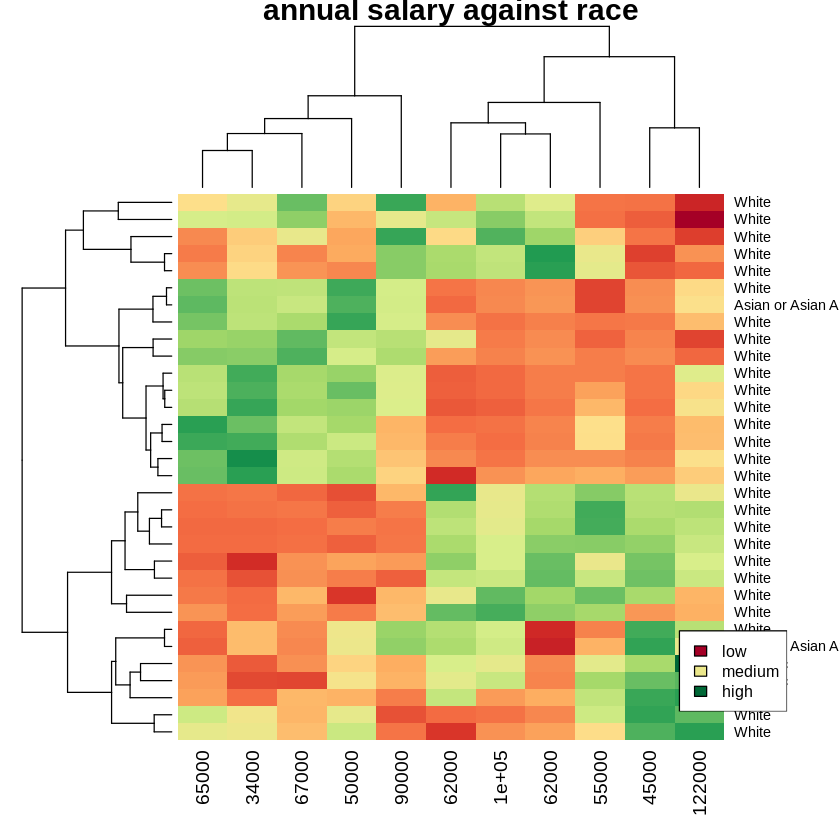

In [53]:
df = df_reg
library("RColorBrewer")
heatmap(scale(mtcars), col=colorRampPalette(brewer.pal(10, "RdYlGn"))(256), labRow=df$industry, labCol=df$annual_salary, main = "annual salary against industry")
legend(x = "bottomright", legend = c("low", "medium", "high"), cex = 0.8, fill = colorRampPalette(brewer.pal(10, "RdYlGn"))(3))
# x11()
heatmap(scale(mtcars), col=colorRampPalette(brewer.pal(10, "RdYlGn"))(256), labRow=df$state, labCol=df$annual_salary, main = "annual salary against state")
legend(x = "bottomright", legend = c("low", "medium", "high"), cex = 0.8, fill = colorRampPalette(brewer.pal(10, "RdYlGn"))(3))
# x11()
heatmap(scale(mtcars), col=colorRampPalette(brewer.pal(10, "RdYlGn"))(256), labRow=df$gender, labCol=df$annual_salary, main = "annual salary against gender")
legend(x = "bottomright", legend = c("low", "medium", "high"), cex = 0.8, fill = colorRampPalette(brewer.pal(10, "RdYlGn"))(3))
# x11()
heatmap(scale(mtcars), col=colorRampPalette(brewer.pal(10, "RdYlGn"))(256), labRow=df$race, labCol=df$annual_salary, main = "annual salary against race")
legend(x = "bottomright", legend = c("low", "medium", "high"), cex = 0.8, fill = colorRampPalette(brewer.pal(10, "RdYlGn"))(3))